[*********************100%***********************]  1 of 1 completed


C:\Users\mehdi\AppData\Local\Temp\ipykernel_21172\1426140015.py:36: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  inflation_indicator = pd.Series(index=cpi_df.index)
C:\Users\mehdi\AppData\Local\Temp\ipykernel_21172\1426140015.py:37: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  growth_indicator = pd.Series(index=spy_oil_log_ratio.index)


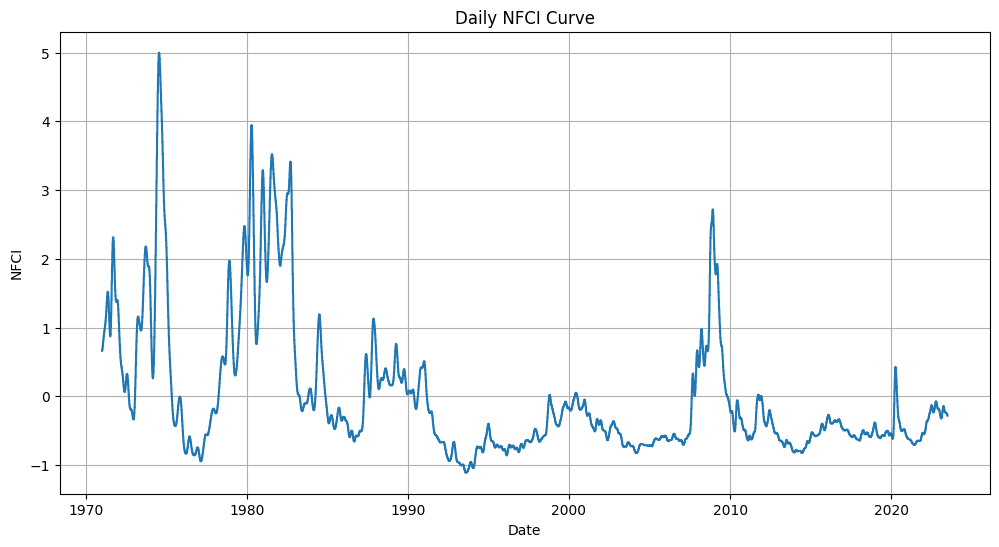

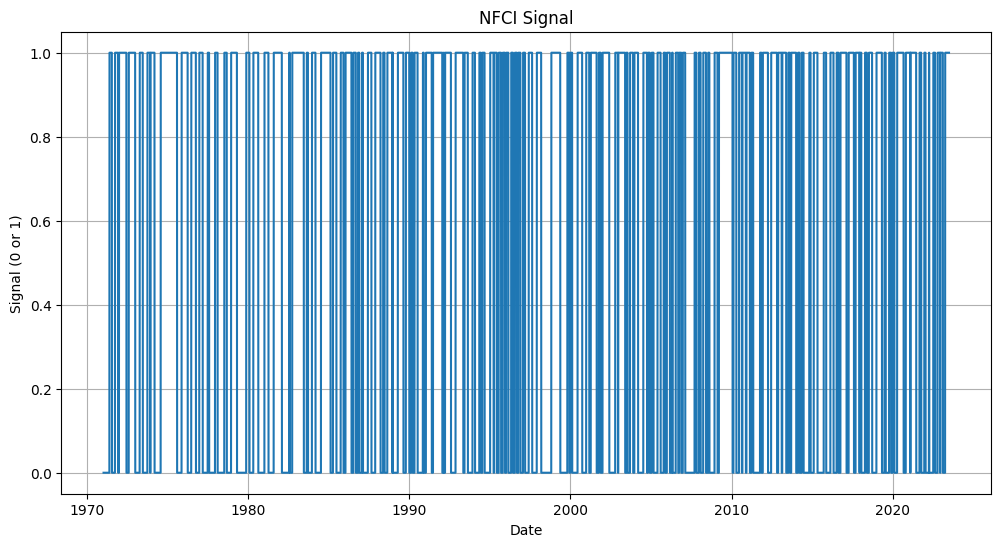

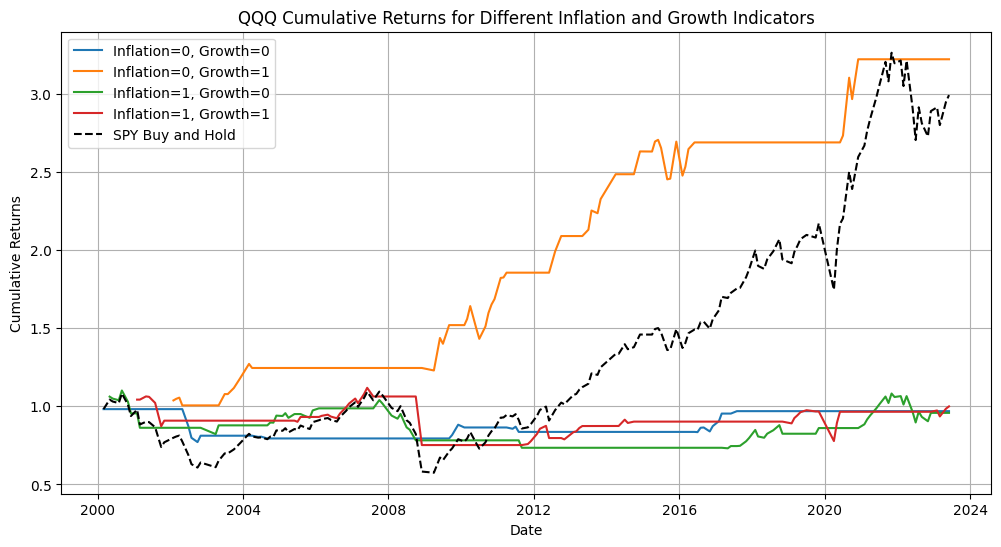

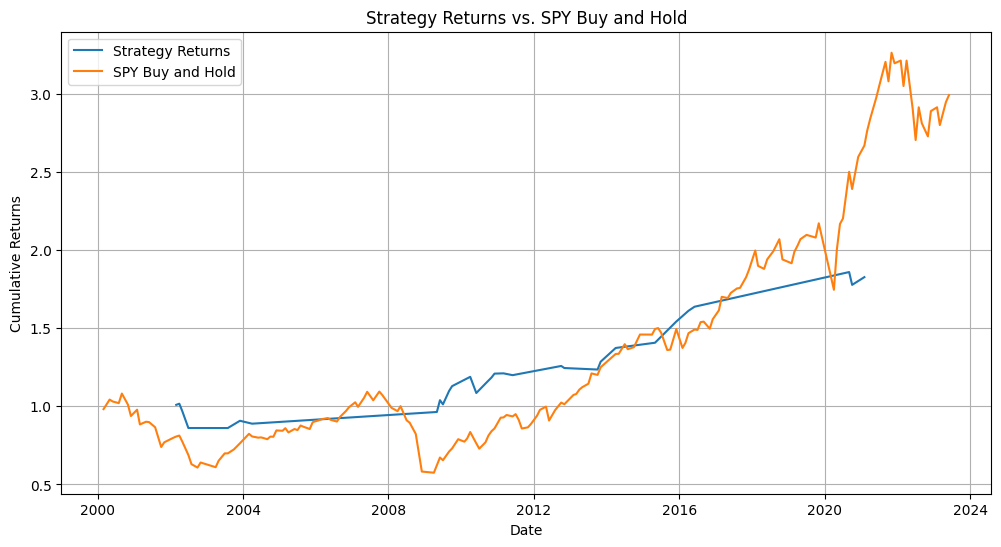

CAGR: 3.24%
Max Drawdown: -15.33%
Sharpe ratio: 6.410909748149221


In [3]:
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import pandas as pd
from fredapi import Fred
from pandas.tseries.offsets import DateOffset
from sklearn.linear_model import LinearRegression

def convert_date_to_ordinal(date):
    return date.toordinal()

def calculate_slope(X, y):
    model = LinearRegression()
    model.fit(X, y)
    return model.coef_[0]

# FRED API Key
fred = Fred(api_key='2f15c96b46530fde1b1992a64c64650e')

# Fetch CPI Data
cpi_data = fred.get_series('CPIAUCSL')
cpi_df = pd.DataFrame(cpi_data, columns=['CPI'])
cpi_df['log_CPI'] = np.log(cpi_df['CPI'])

# Fetch SPY Data
spy = yf.download('SPY', start='2000-01-01', end='2023-06-19')
spy_close = spy['Close']

# Fetch Oil Price Data
oil_price = fred.get_series('DCOILWTICO')
oil_price = oil_price[oil_price > 0]  # Keep only positive values for log
oil_log = np.log(oil_price.dropna())  # Drop NaN and calculate log
spy_oil_log_ratio = np.log(spy_close).div(oil_log, axis=0)

# Initialize Indicators
inflation_indicator = pd.Series(index=cpi_df.index)
growth_indicator = pd.Series(index=spy_oil_log_ratio.index)

# Compute Inflation Indicator
for i in range(12 * 7, len(cpi_df)):
    X = cpi_df.index[:i].map(pd.Timestamp.toordinal).values.reshape(-1, 1)
    y = cpi_df['log_CPI'].iloc[:i].values

    model_1 = LinearRegression()
    model_1.fit(X[-12:], y[-12:])

    model_7 = LinearRegression()
    model_7.fit(X[-12 * 7:], y[-12 * 7:])

    y_pred_1 = model_1.predict([X[-1]])
    y_pred_7 = model_7.predict([X[-1]])

    inflation_indicator.iloc[i] = 1 if y_pred_7[-1] < y_pred_1[-1] else 0

# Compute Growth Indicator
for date in spy_oil_log_ratio.index:
    one_year_ago = date - DateOffset(years=1)
    last_year_data = spy_oil_log_ratio[(spy_oil_log_ratio.index >= one_year_ago) & (spy_oil_log_ratio.index < date)].dropna()  # Drop NaN values
    seven_years_ago = date - DateOffset(years=7)
    last_seven_years_data = spy_oil_log_ratio[(spy_oil_log_ratio.index >= seven_years_ago) & (spy_oil_log_ratio.index < date)].dropna()  # Drop NaN values
    
    if not last_year_data.empty and not last_seven_years_data.empty:
        X1 = np.array(last_year_data.index.map(convert_date_to_ordinal)).reshape(-1, 1)
        y1 = last_year_data.values
        X7 = np.array(last_seven_years_data.index.map(convert_date_to_ordinal)).reshape(-1, 1)
        y7 = last_seven_years_data.values
        growth_indicator[date] = int(calculate_slope(X7, y7) < calculate_slope(X1, y1))


# Here, you can use 'inflation_indicator' and 'growth_indicator' for further analysis or backtesting.
# Merge the inflation_indicator and growth_indicator
indicators = pd.concat([inflation_indicator, growth_indicator], axis=1)
indicators.columns = ['inflation_indicator', 'growth_indicator']
indicators = indicators.dropna()


#Risk-off indicator

# Read the data
nfci_data = pd.read_csv('nfci.csv')
# Convert the 'DATE' column to datetime
nfci_data['date'] = pd.to_datetime(nfci_data['DATE'])
# Set the index to the 'date' column and drop the old 'DATE' column
nfci_data.set_index('date', inplace=True)
nfci_data.drop(columns=['DATE'], inplace=True)
# Resample the data to daily frequency (use 'ffill' to forward fill the missing values)
nfci_data_daily = nfci_data.resample("D").ffill()
# Calculate the 14-day moving average
nfci_data_daily['nfci_sma_14'] = nfci_data_daily['NFCI'].rolling(window=14).mean()
# Create a signal
nfci_data_daily['signal'] = np.where(nfci_data_daily['NFCI'] < nfci_data_daily['nfci_sma_14'], 1, 0)

# Plot daily NFCI curve
plt.figure(figsize=(12, 6))
plt.plot(nfci_data_daily.index, nfci_data_daily['NFCI'])
plt.xlabel('Date')
plt.ylabel('NFCI')
plt.title('Daily NFCI Curve')
plt.grid()
plt.show()

# Plot NFCI signal
plt.figure(figsize=(12, 6))
plt.plot(nfci_data_daily.index, nfci_data_daily['signal'])
plt.xlabel('Date')
plt.ylabel('Signal (0 or 1)')
plt.title('NFCI Signal')
plt.grid()
plt.show()

# Merge with SPY close prices
merged_data = pd.concat([spy_close, indicators], axis=1).dropna()

# Compute daily returns for SPY
merged_data['spy_returns'] = merged_data['Close'].pct_change()

# Cumulative returns for different combinations of inflation and growth indicators
merged_data['cum_returns_00'] = (1 + merged_data.loc[(merged_data['inflation_indicator'] == 0) & (merged_data['growth_indicator'] == 0), 'spy_returns']).cumprod()
merged_data['cum_returns_01'] = (1 + merged_data.loc[(merged_data['inflation_indicator'] == 0) & (merged_data['growth_indicator'] == 1), 'spy_returns']).cumprod()
merged_data['cum_returns_10'] = (1 + merged_data.loc[(merged_data['inflation_indicator'] == 1) & (merged_data['growth_indicator'] == 0), 'spy_returns']).cumprod()
merged_data['cum_returns_11'] = (1 + merged_data.loc[(merged_data['inflation_indicator'] == 1) & (merged_data['growth_indicator'] == 1), 'spy_returns']).cumprod()

# Forward filling
merged_data[['cum_returns_00', 'cum_returns_01', 'cum_returns_10', 'cum_returns_11']] = merged_data[['cum_returns_00', 'cum_returns_01', 'cum_returns_10', 'cum_returns_11']].fillna(method='ffill')

# Compute SPY Buy and Hold cumulative returns
merged_data['cum_returns_buy_and_hold'] = (1 + merged_data['spy_returns']).cumprod()

# Plot cumulative returns
plt.figure(figsize=(12, 6))
plt.plot(merged_data.index, merged_data['cum_returns_00'], label='Inflation=0, Growth=0')
plt.plot(merged_data.index, merged_data['cum_returns_01'], label='Inflation=0, Growth=1')
plt.plot(merged_data.index, merged_data['cum_returns_10'], label='Inflation=1, Growth=0')
plt.plot(merged_data.index, merged_data['cum_returns_11'], label='Inflation=1, Growth=1')
plt.plot(merged_data.index, merged_data['cum_returns_buy_and_hold'], label='SPY Buy and Hold', color='black', linestyle='--')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.title('QQQ Cumulative Returns for Different Inflation and Growth Indicators')
plt.grid()
plt.show()

# Merge with NFCI data
merged_data = merged_data.merge(nfci_data_daily[['NFCI', 'signal']], how='left', left_index=True, right_index=True)
# Filtering for days when inflation_indicator is 0, growth_indicator is 1, and NFCI signal is 1
invested = merged_data[(merged_data['inflation_indicator'].shift(1) == 0) & (merged_data['growth_indicator'].shift(1) == 1) & (merged_data['signal'].shift(1) == 1)].copy()
# Calculating daily portfolio value
invested['daily_portfolio_value'] = (1 + invested['spy_returns']).cumprod()

# Calculate SPY Buy and Hold cumulative returns
spy_cum_returns_buy_and_hold = (1 + merged_data['spy_returns']).cumprod()
# Plot cumulative returns
plt.figure(figsize=(12, 6))
plt.plot(invested.index, invested['daily_portfolio_value'], label='Strategy Returns')
plt.plot(merged_data.index, spy_cum_returns_buy_and_hold, label='SPY Buy and Hold')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.title('Strategy Returns vs. SPY Buy and Hold')
plt.grid()
plt.show()

# CAGR
years = (invested.index[-1] - invested.index[0]).days / 365.25
CAGR = (invested['daily_portfolio_value'][-1]) ** (1 / years) - 1
# Max Drawdown
invested['cumulative_max_value'] = invested['daily_portfolio_value'].cummax()
invested['drawdown'] = invested['daily_portfolio_value'] / invested['cumulative_max_value'] - 1
max_drawdown = invested['drawdown'].min()
# Sharpe Ratio (assuming 0% risk-free rate)
daily_rf_rate = 0  # Assuming 0% risk-free rate
excess_daily_returns = invested['spy_returns'] - daily_rf_rate
sharpe_ratio = np.mean(excess_daily_returns) / np.std(excess_daily_returns) * np.sqrt(252)  # Annualized
# Output the metrics
print(f"CAGR: {CAGR * 100:.2f}%")
print(f"Max Drawdown: {max_drawdown * 100:.2f}%")
print(f"Sharpe ratio: {sharpe_ratio}")

[*********************100%***********************]  11 of 11 completed
[*********************100%***********************]  1 of 1 completed


C:\Users\mehdi\AppData\Local\Temp\ipykernel_21172\2319635415.py:59: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  inflation_indicator = pd.Series(index=cpi_df.index)
C:\Users\mehdi\AppData\Local\Temp\ipykernel_21172\2319635415.py:60: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  growth_indicator = pd.Series(index=spy_oil_log_ratio.index)


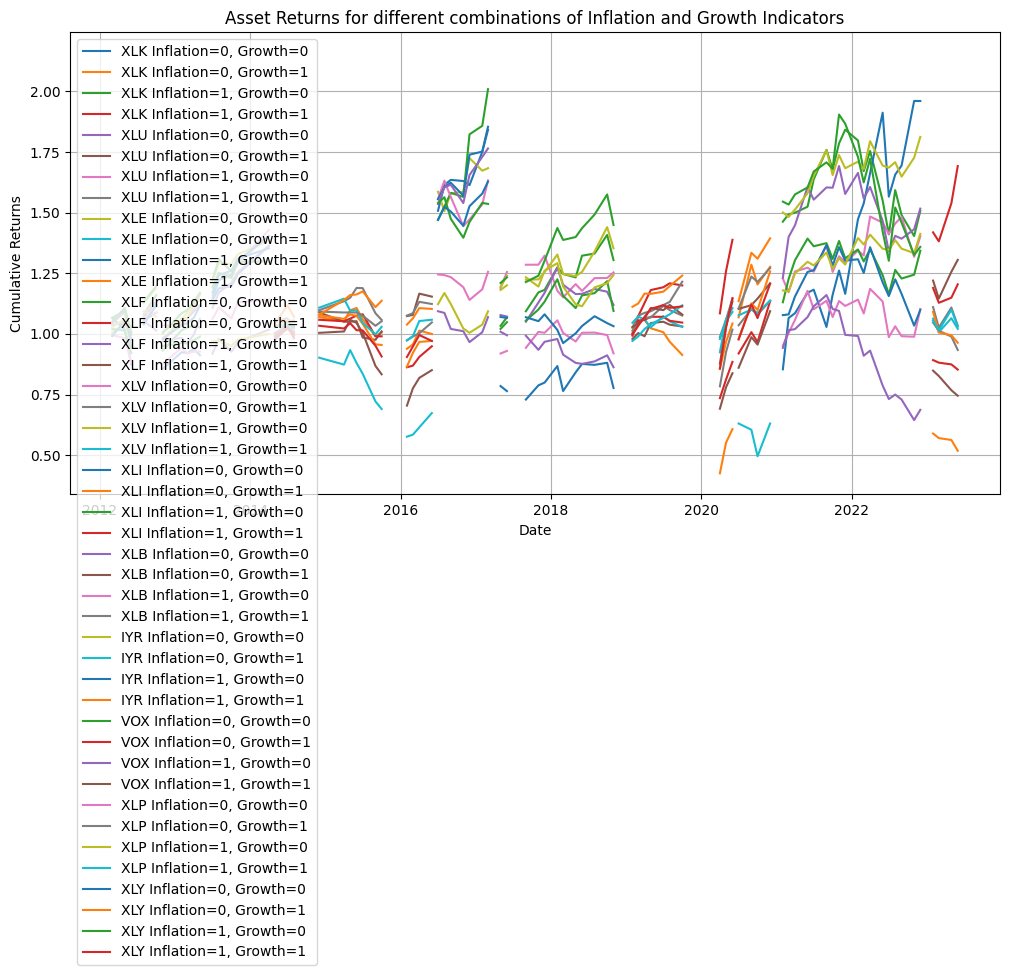

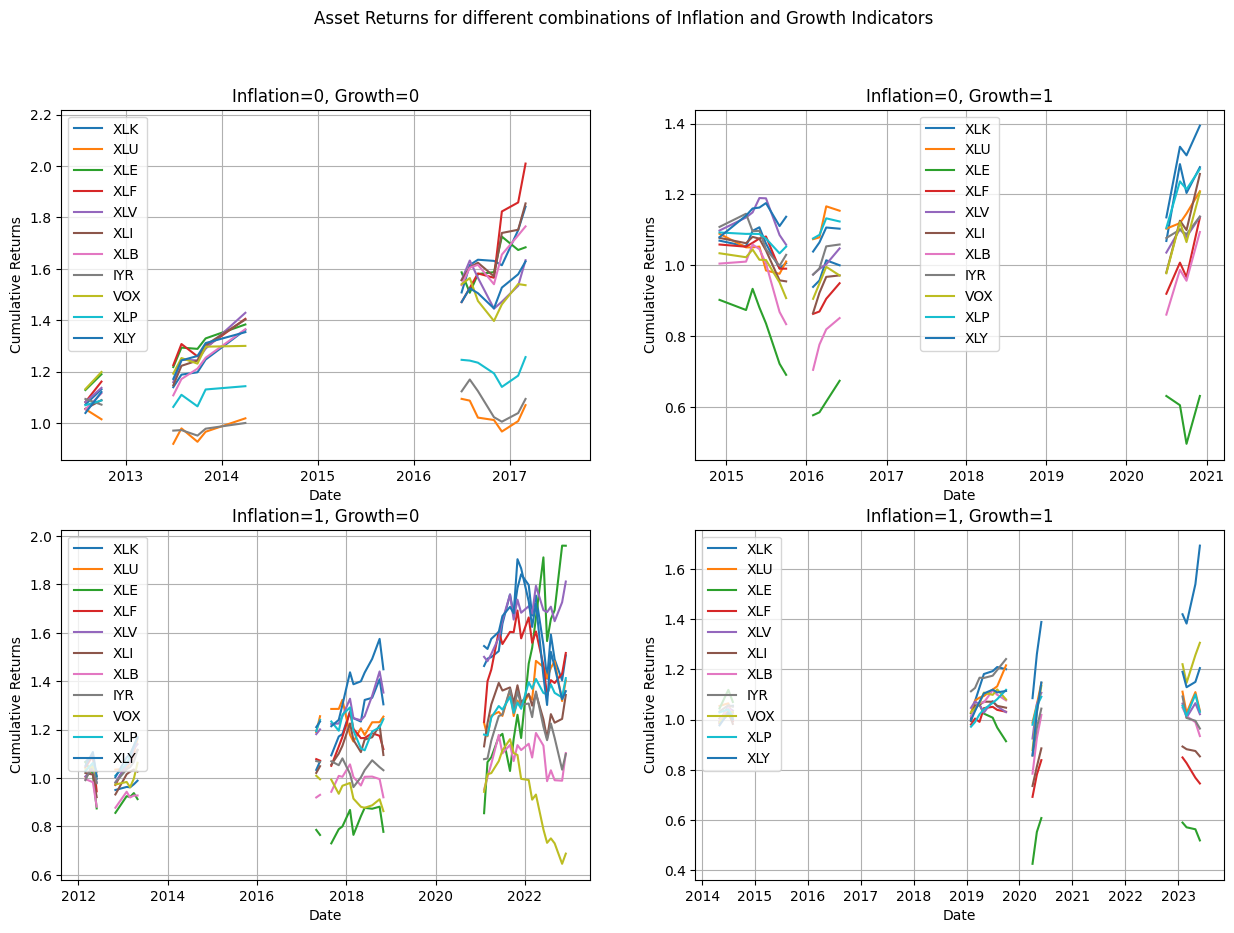

C:\Users\mehdi\AppData\Local\Temp\ipykernel_21172\2319635415.py:151: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  portfolio = pd.Series(index=merged_data.index)


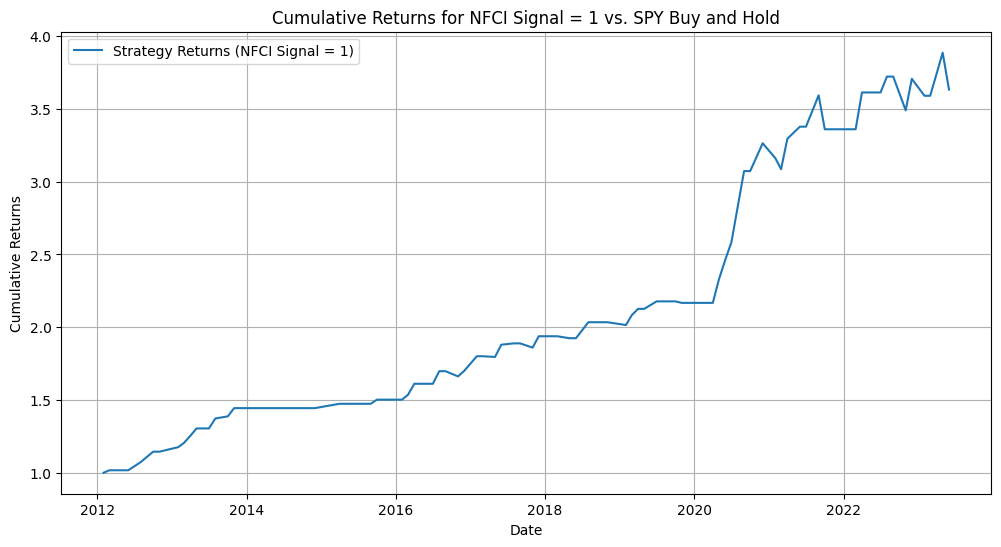

CAGR: 0.12060983922594448
Max Drawdown: -0.06519528351040493
Sharpe Ratio: 0.6360261763745376
[*********************100%***********************]  1 of 1 completed


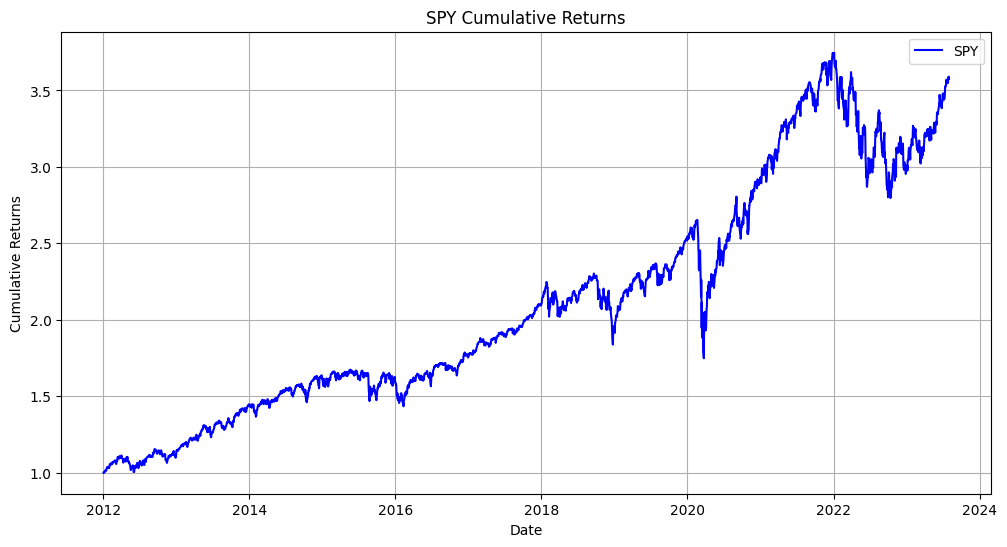

SPY Sharpe Ratio: 0.04638098289385218


In [4]:
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import pandas as pd
from fredapi import Fred
from pandas.tseries.offsets import DateOffset
from sklearn.linear_model import LinearRegression

def convert_date_to_ordinal(date):
    return date.toordinal()

# FRED API Key
fred = Fred(api_key='2f15c96b46530fde1b1992a64c64650e')

# Fetch CPI Data
cpi_data = fred.get_series('CPIAUCSL')
cpi_df = pd.DataFrame(cpi_data, columns=['CPI'])
cpi_df['log_CPI'] = np.log(cpi_df['CPI'])

def calculate_slope(X, y):
    """Fit a linear regression model and return the slope"""
    model = LinearRegression()
    model.fit(X, y)
    return model.coef_[0]

assets=['XLK', 'XLU', 'XLE', 'XLF','XLV','XLI','XLB', 'IYR', 'VOX', 'XLP', 'XLY']
#assets=['XLK', 'XLU', 'XLE', 'XLF','XLV','XLI','XLB', 'IYR', 'VOX', 'XLP', 'XLY']


asset_data =  yf.download(assets, start='2012-01-01')['Close']

# Fetch SPY Data
spy = yf.download('SPY', start='2012-01-01')
spy_close = spy['Close']

# Fetch Oil Price Data
oil_price = fred.get_series('DCOILWTICO')
oil_price = oil_price[oil_price > 0]  # Keep only positive values for log
oil_log = np.log(oil_price.dropna())  # Drop NaN and calculate log
spy_oil_log_ratio = np.log(spy_close).div(oil_log, axis=0)


#Fetch NFCI data
# Read the data
nfci_data = pd.read_csv('nfci.csv')
# Convert the 'DATE' column to datetime
nfci_data['date'] = pd.to_datetime(nfci_data['DATE'])
# Set the index to the 'date' column and drop the old 'DATE' column
nfci_data.set_index('date', inplace=True)
nfci_data.drop(columns=['DATE'], inplace=True)
# Resample the data to daily frequency (use 'ffill' to forward fill the missing values)
nfci_data_daily = nfci_data.resample("D").ffill()
# Calculate the 14-day moving average
nfci_data_daily['nfci_sma_14'] = nfci_data_daily['NFCI'].rolling(window=14).mean()
# Create a signal
nfci_data_daily['signal'] = np.where(nfci_data_daily['NFCI'] < nfci_data_daily['nfci_sma_14'], 1, 0)

# Initialize Indicators
inflation_indicator = pd.Series(index=cpi_df.index)
growth_indicator = pd.Series(index=spy_oil_log_ratio.index)

# Compute Inflation Indicator
for i in range(12 * 7, len(cpi_df)):
    X = cpi_df.index[:i].map(pd.Timestamp.toordinal).values.reshape(-1, 1)
    y = cpi_df['log_CPI'].iloc[:i].values

    model_1 = LinearRegression()
    model_1.fit(X[-12:], y[-12:])

    model_7 = LinearRegression()
    model_7.fit(X[-12 * 7:], y[-12 * 7:])

    y_pred_1 = model_1.predict([X[-1]])
    y_pred_7 = model_7.predict([X[-1]])

    inflation_indicator.iloc[i] = 1 if y_pred_7[-1] < y_pred_1[-1] else 0

# Compute Growth Indicator
for date in spy_oil_log_ratio.index:
    one_year_ago = date - DateOffset(years=1)
    last_year_data = spy_oil_log_ratio[(spy_oil_log_ratio.index >= one_year_ago) & (spy_oil_log_ratio.index < date)].dropna()
    seven_years_ago = date - DateOffset(years=7)
    last_seven_years_data = spy_oil_log_ratio[(spy_oil_log_ratio.index >= seven_years_ago) & (spy_oil_log_ratio.index < date)].dropna()
    
    if not last_year_data.empty and not last_seven_years_data.empty:
        X1 = np.array(last_year_data.index.map(convert_date_to_ordinal)).reshape(-1, 1)
        y1 = last_year_data.values
        X7 = np.array(last_seven_years_data.index.map(convert_date_to_ordinal)).reshape(-1, 1)
        y7 = last_seven_years_data.values
        growth_indicator[date] = int(calculate_slope(X7, y7) < calculate_slope(X1, y1))

        
        
# Here, you can use 'inflation_indicator' and 'growth_indicator' for further analysis or backtesting.
# Merge the inflation_indicator and growth_indicator
indicators = pd.concat([inflation_indicator, growth_indicator], axis=1)
indicators.columns = ['inflation_indicator', 'growth_indicator']
indicators = indicators.dropna()

# After computing the indicators, merge them with asset data
merged_data = pd.concat([asset_data, indicators], axis=1).dropna()
# After computing the indicators, merge them with asset data and NFCI signal
merged_data = pd.concat([asset_data, indicators, nfci_data_daily['signal']], axis=1).dropna()

# Compute daily returns for assets
for asset in assets:
    merged_data[f'{asset.lower()}_returns'] = merged_data[asset].pct_change()

# Cumulative returns for different combinations of inflation and growth indicators for each asset
combinations = [(0, 0), (0, 1), (1, 0), (1, 1)]
for asset in assets:
    for inflation, growth in combinations:
        col_name = f'cum_returns_{inflation}{growth}_{asset.lower()}'
        returns_col = f'{asset.lower()}_returns'
        merged_data[col_name] = (1 + merged_data.loc[(merged_data['inflation_indicator'] == inflation) & (merged_data['growth_indicator'] == growth), returns_col]).cumprod()

# Plot cumulative returns for each asset
plt.figure(figsize=(12, 6))
for asset in assets:
    for inflation, growth in combinations:
        col_name = f'cum_returns_{inflation}{growth}_{asset.lower()}'
        plt.plot(merged_data.index, merged_data[col_name], label=f'{asset} Inflation={inflation}, Growth={growth}')

plt.legend()
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.title('Asset Returns for different combinations of Inflation and Growth Indicators')
plt.grid()
plt.show()

# Plot cumulative returns for each asset for different combinations of Inflation and Growth Indicators
combinations = [(0, 0), (0, 1), (1, 0), (1, 1)]
fig, axs = plt.subplots(2, 2, figsize=(15, 10))

for i, (inflation, growth) in enumerate(combinations):
    ax = axs[i // 2, i % 2]
    for asset in assets:
        col_name = f'cum_returns_{inflation}{growth}_{asset.lower()}'
        ax.plot(merged_data.index, merged_data[col_name], label=f'{asset}')
        
    ax.legend()
    ax.set_xlabel('Date')
    ax.set_ylabel('Cumulative Returns')
    ax.set_title(f'Inflation={inflation}, Growth={growth}')
    ax.grid()

fig.suptitle('Asset Returns for different combinations of Inflation and Growth Indicators')
plt.show()

# Initialize portfolio
portfolio = pd.Series(index=merged_data.index)

# Define the investment strategy
for date in merged_data.index:
    inflation_indicator = merged_data.loc[date, 'inflation_indicator']
    growth_indicator = merged_data.loc[date, 'growth_indicator']
    signal= merged_data.loc[date, 'signal']

    if inflation_indicator == 0 and growth_indicator == 1 and signal == 1:
        portfolio[date] = merged_data.loc[date, 'xlk_returns'] * 0.5 + merged_data.loc[date, 'xly_returns'] * 0.5
    elif inflation_indicator == 1 and growth_indicator == 1 and signal == 1:
        portfolio[date] = merged_data.loc[date, 'xlp_returns'] * 0.5 + merged_data.loc[date, 'xlu_returns'] * 0.5
    elif inflation_indicator == 1 and growth_indicator == 0 and signal == 1:
        portfolio[date] = merged_data.loc[date, 'xlp_returns'] * 0.5 + merged_data.loc[date, 'xlu_returns'] * 0.5
    elif inflation_indicator == 0 and growth_indicator == 0 and signal == 1:
        portfolio[date] = merged_data.loc[date, 'xlk_returns'] * 0.5 + merged_data.loc[date, 'xly_returns'] * 0.5

# Calculate cumulative portfolio returns
portfolio_cumulative_returns = (1 + portfolio.fillna(0)).cumprod()

# Plot cumulative returns
plt.figure(figsize=(12, 6))
plt.plot(portfolio_cumulative_returns, label='Strategy Returns (NFCI Signal = 1)')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.title('Cumulative Returns for NFCI Signal = 1 vs. SPY Buy and Hold')
plt.grid()
plt.show()


def calculate_cagr(start_value, end_value, periods):
    """
    Compute the Compound Annual Growth Rate
    :param start_value: the initial value of the investment
    :param end_value: the final value of the investment
    :param periods: number of periods
    :return: Compound Annual Growth Rate
    """
    return (end_value / start_value) ** (1/periods) - 1

def calculate_max_drawdown(returns):
    """
    Compute Maximum Drawdown
    :param returns: Portfolio or asset returns
    :return: Maximum drawdown
    """
    cumulative_returns = (1 + returns).cumprod()
    return (cumulative_returns.div(cumulative_returns.cummax()) - 1).min()


def calculate_sharpe_ratio(returns, rf=0):
    """
    Compute Sharpe Ratio
    :param returns: Portfolio or asset returns
    :param rf: Risk-free rate (default: 0)
    :return: Sharpe ratio
    """
    return (returns.mean() - rf) / returns.std()


# Calculate CAGR
start_value = portfolio_cumulative_returns.iloc[0]
end_value = portfolio_cumulative_returns.iloc[-1]
periods = (portfolio_cumulative_returns.index[-1] - portfolio_cumulative_returns.index[0]).days / 365.25
cagr = calculate_cagr(start_value, end_value, periods)
print(f'CAGR: {cagr}')

# Calculate Max Drawdown
max_drawdown = calculate_max_drawdown(portfolio)
print(f'Max Drawdown: {max_drawdown}')

# Calculate Sharpe Ratio for our strategy
sharpe_ratio = calculate_sharpe_ratio(portfolio)
print(f'Sharpe Ratio: {sharpe_ratio}')

# Fetch QQQ data
spy_data = yf.download('SPY', start='2012-01-01')['Close']
spy_returns = spy_data.pct_change()

# Calculate cumulative returns for QQQ
spy_cumulative_returns = (1 + spy_returns.fillna(0)).cumprod()

# Plot cumulative QQQ returns
plt.figure(figsize=(12, 6))
plt.plot(spy_cumulative_returns.index, spy_cumulative_returns, label='SPY', color='blue')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.title('SPY Cumulative Returns')
plt.grid()
plt.show()

# Calculate Sharpe Ratio for SPY for comparison
spy_sharpe_ratio = calculate_sharpe_ratio(spy_returns)
print(f'SPY Sharpe Ratio: {spy_sharpe_ratio}')
